
📊 Evaluation Report
              precision    recall  f1-score   support

           0       0.25      0.36      0.29      1067
           1       0.89      0.82      0.85      6429

    accuracy                           0.75      7496
   macro avg       0.57      0.59      0.57      7496
weighted avg       0.79      0.75      0.77      7496

Accuracy: 0.754
F1 Score: 0.851
ROC AUC: 0.671


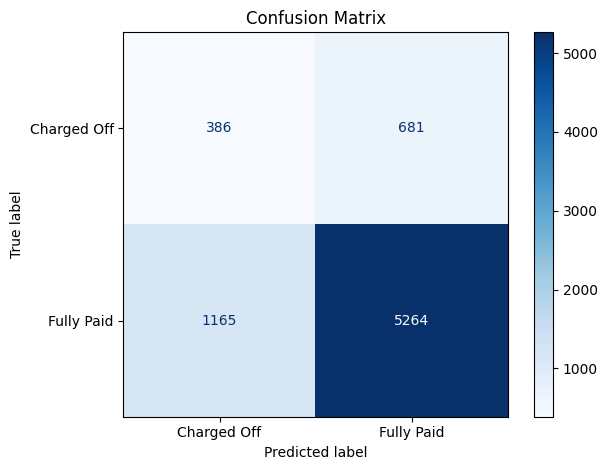

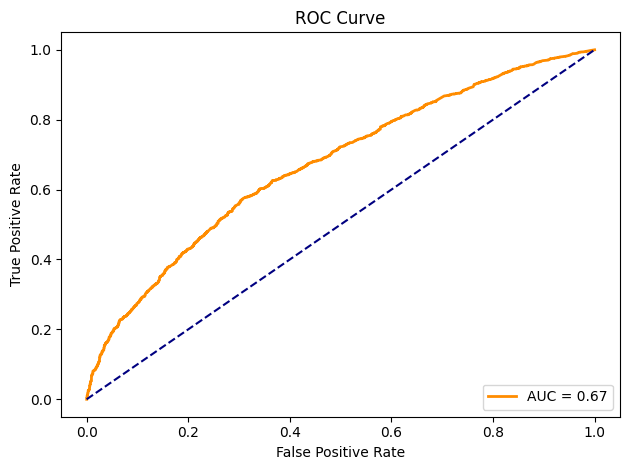

✅ Model saved successfully.


In [5]:
# 1. Import Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier  # ✅ XGBoost model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    classification_report, accuracy_score, f1_score,
    confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import joblib
import os
import sys
from imblearn.over_sampling import SMOTE

# 2. Load Dataset
try:
    df = pd.read_csv("financial_loan.csv")
except FileNotFoundError:
    print("❌ File 'financial_loan.csv' not found.")
    sys.exit()

# 3. Clean and Select Features
required_columns = ['loan_amount', 'annual_income', 'int_rate', 'dti',
                    'emp_length', 'purpose', 'grade', 'home_ownership', 'loan_status']

missing = [col for col in required_columns if col not in df.columns]
if missing:
    print(f"❌ Missing required columns: {missing}")
    sys.exit()

df = df[required_columns].dropna()
df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off'])]
df['loan_status'] = df['loan_status'].map({'Fully Paid': 1, 'Charged Off': 0})

# 4. Define Feature Lists
numerical = ['loan_amount', 'annual_income', 'int_rate', 'dti']
categorical = ['emp_length', 'purpose', 'grade', 'home_ownership']
features = numerical + categorical

# 5. Preprocessing Pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
])


# 6. Model Pipeline (XGBoost only)
classifier = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    eval_metric='logloss',
    random_state=42
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

# 7. Train/Test Split
X = df[features]
y = df['loan_status']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42)

# 8. Apply SMOTE
X_train_transformed = preprocessor.fit_transform(X_train)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)

# 9. Train Model on Resampled Data
pipeline.named_steps['classifier'].fit(X_train_resampled, y_train_resampled)
pipeline.steps[0] = ('preprocessor', preprocessor)  # Reattach the fitted preprocessor

# 10. Evaluate
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

print("\n📊 Evaluation Report")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.3f}")

# Confusion Matrix
try:
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Charged Off", "Fully Paid"])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"⚠️ Could not display confusion matrix: {e}")

# ROC Curve
try:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}")
    plt.plot([0, 1], [0, 1], 'navy', linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"⚠️ Could not display ROC curve: {e}")

# 11. Save Model and Features
try:
    joblib.dump(pipeline, 'logreg_model_compatible.pkl')
    joblib.dump(features, 'model_features.pkl')
    print("✅ Model saved successfully.")
except Exception as e:
    print(f"❌ Save failed: {e}")
